In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [2]:
data_dir = '../data/Screwdriving Model Experiments'
out_dir = '../data/sindy-data'
observation_file = 'smoothed_observation_data.csv'
sensor_file = 'sensor_data.csv'
merged_file = 'merged_data.csv'
train_file = 'train_data.csv'
validation_file = 'val_data.csv'
test_file = 'test_data.csv'
subdirs = os.listdir(data_dir)
files = list(map(lambda sd: os.path.join(data_dir, sd, observation_file), subdirs))
# files

In [3]:
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# df.head()

In [4]:
df.isna().sum()

time    0
X       0
Y       0
Z       0
dtype: int64

In [5]:
# df.describe()

4.57769


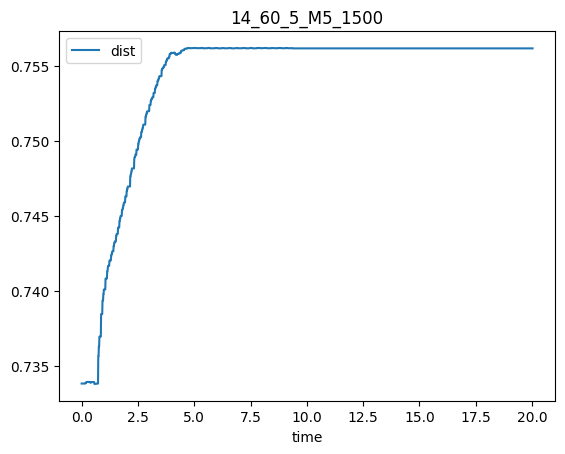

2.903985


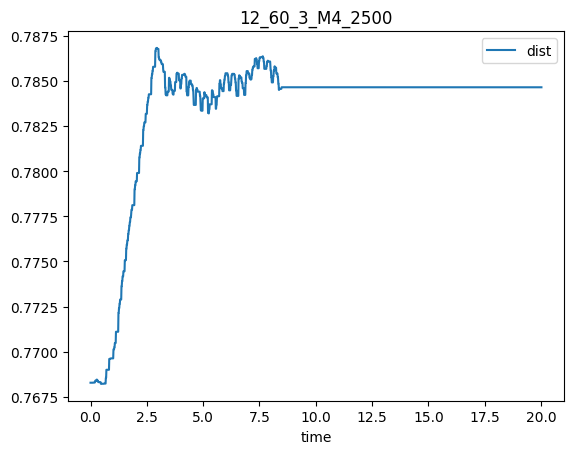

3.322185


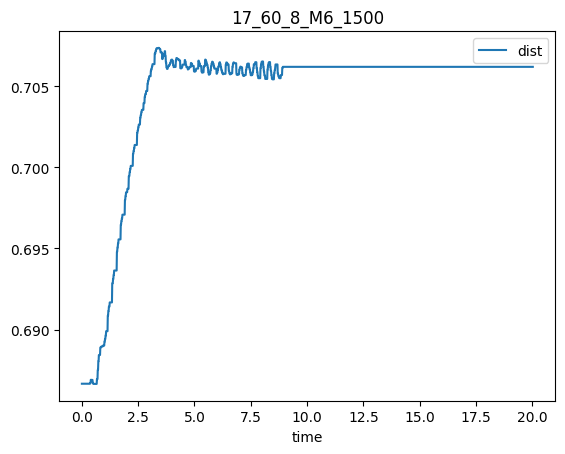

8.511759


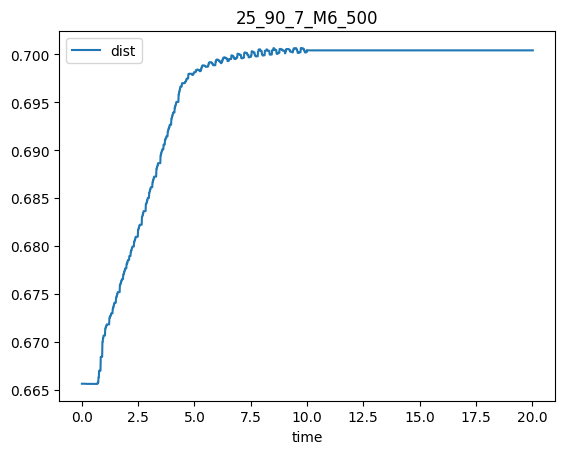

0.0


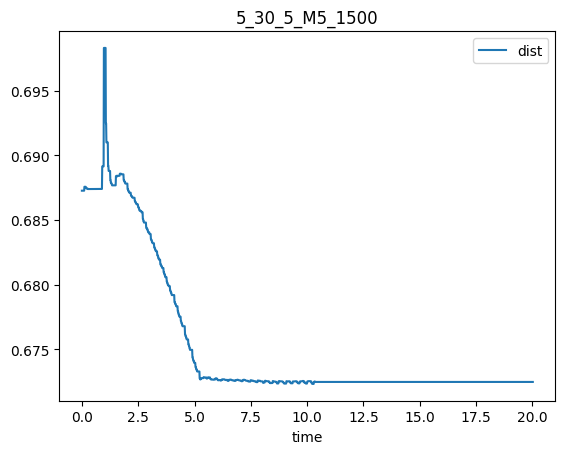

3.833257


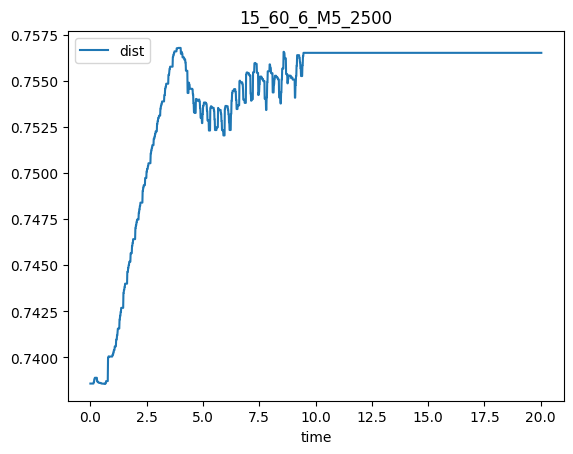

5.31185


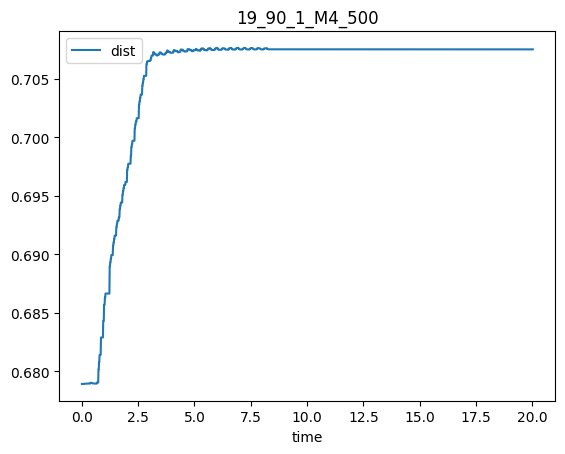

0.0


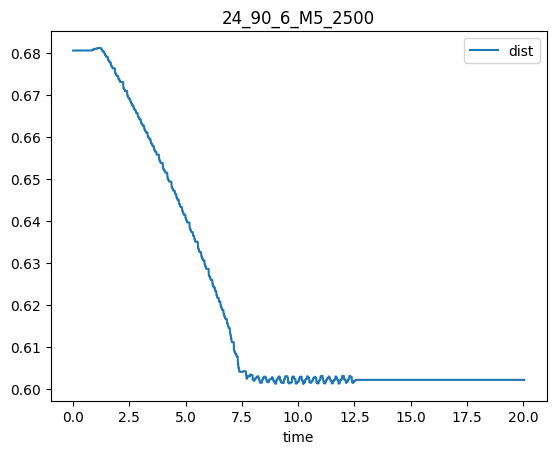

0.0


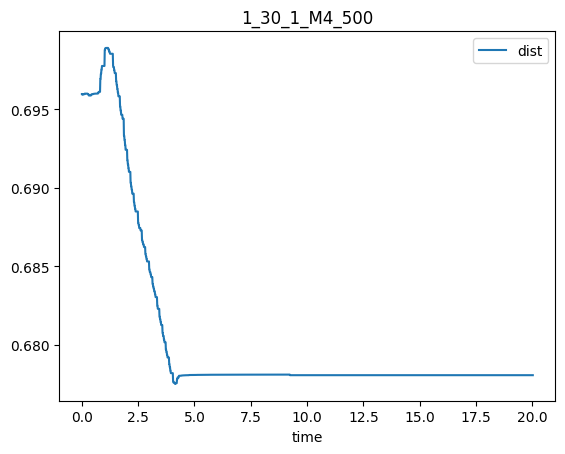

3.277385


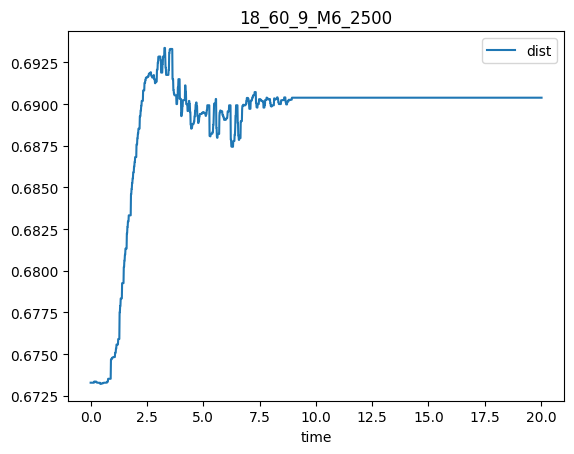

0.0


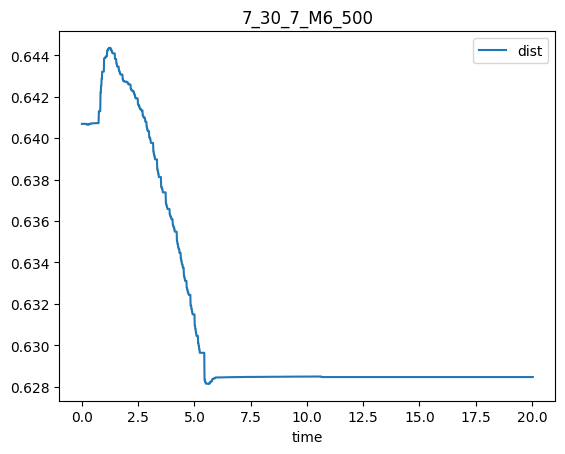

4.111444


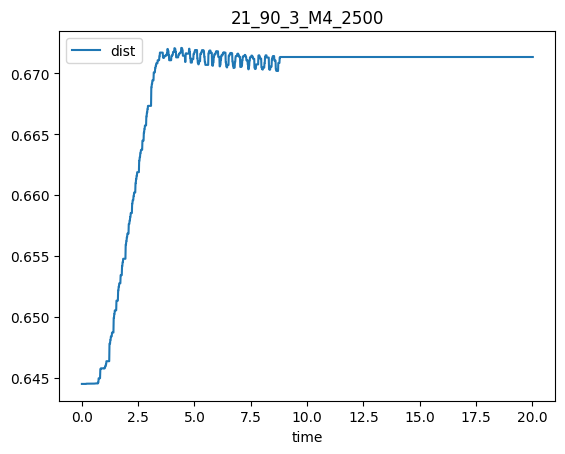

3.083161


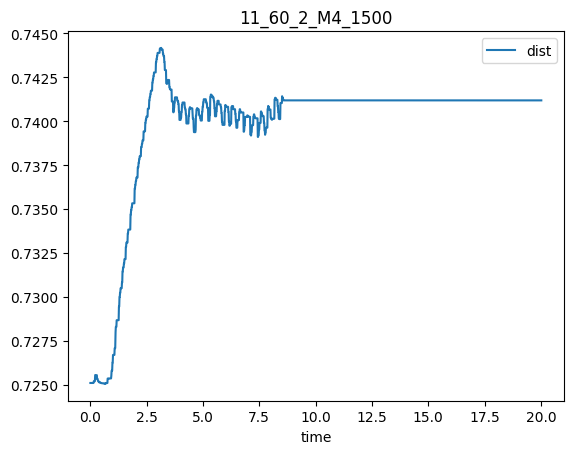

0.0


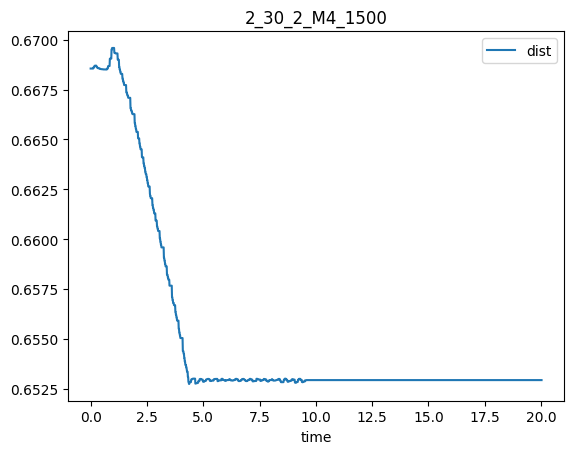

3.332682


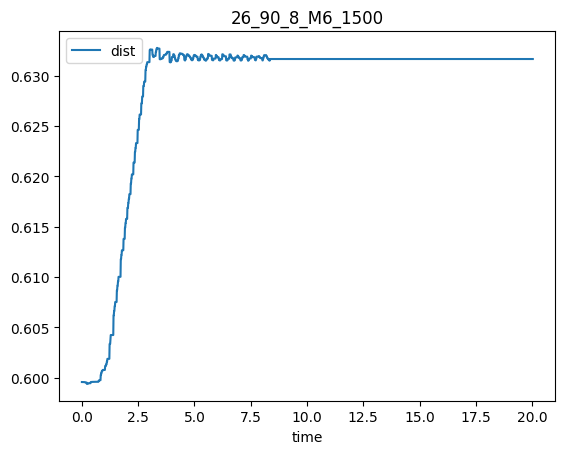

0.0


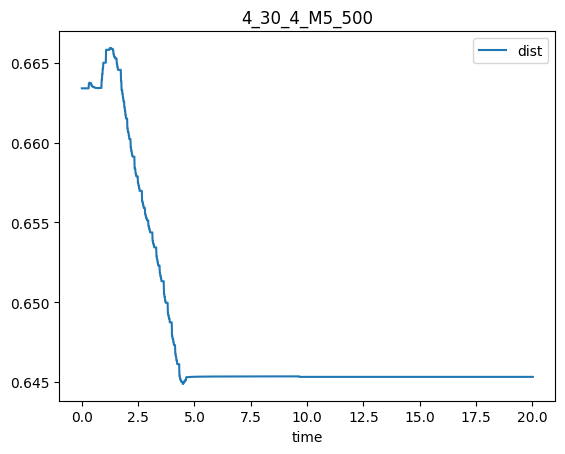

0.0


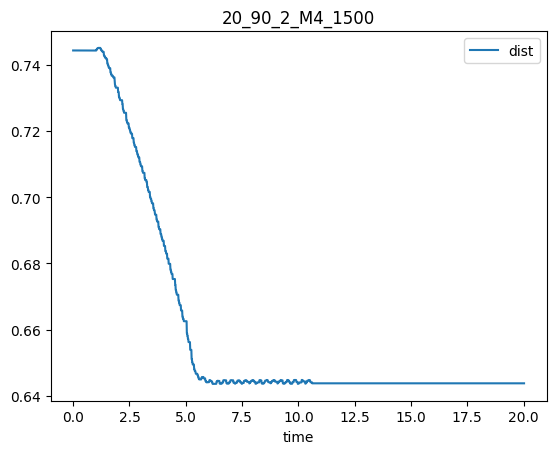

4.278586


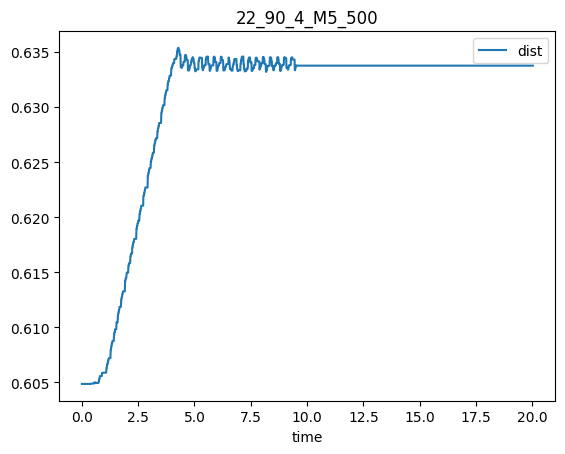

0.0


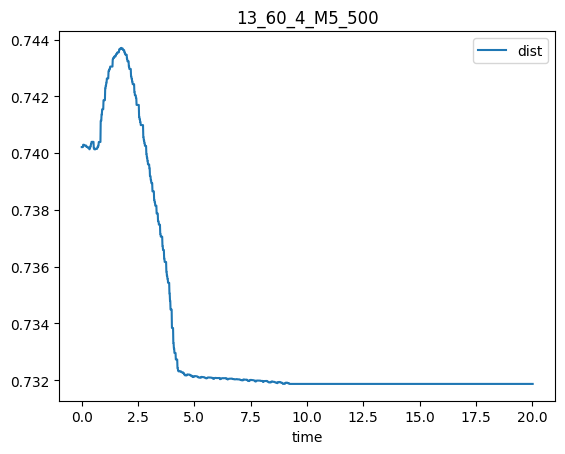

3.723399


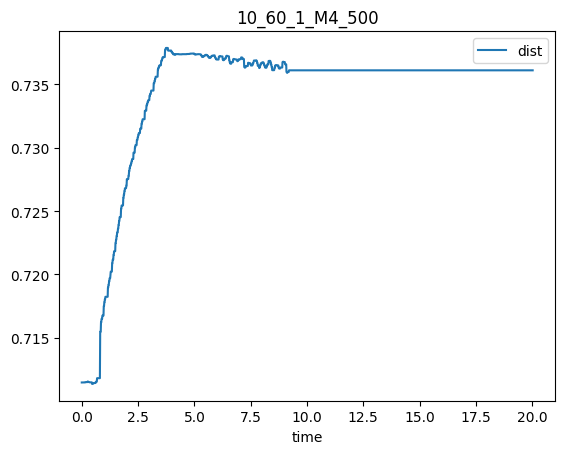

3.746236


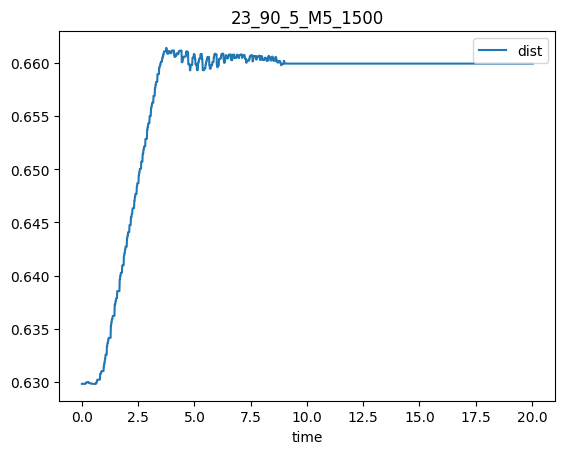

0.0


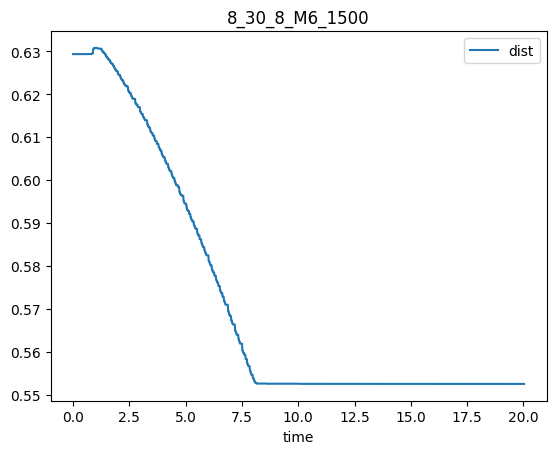

0.0


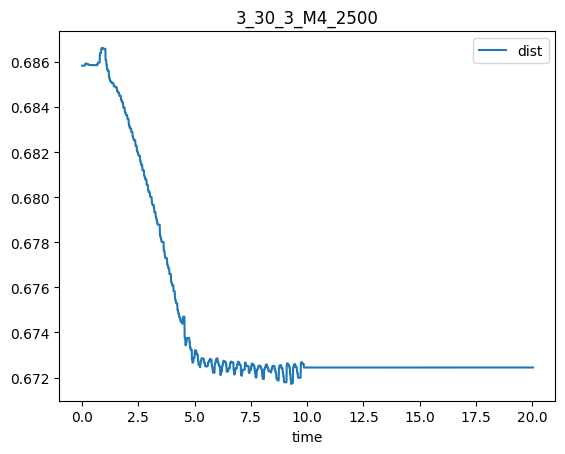

0.0


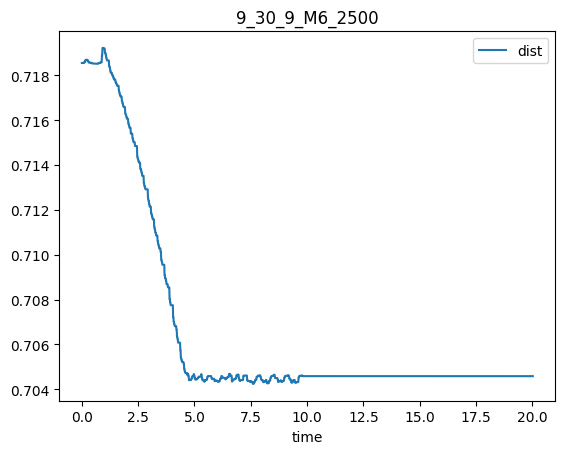

3.45216


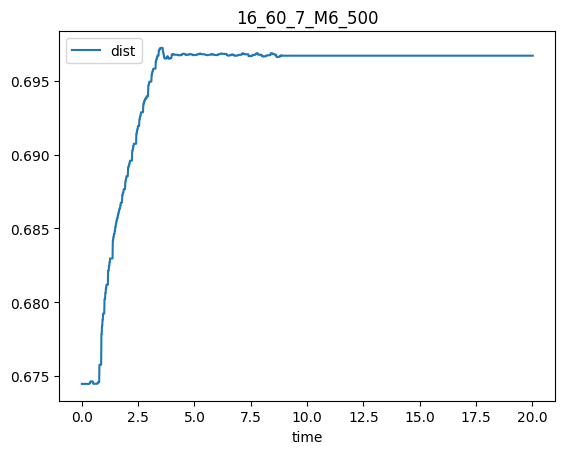

3.756909


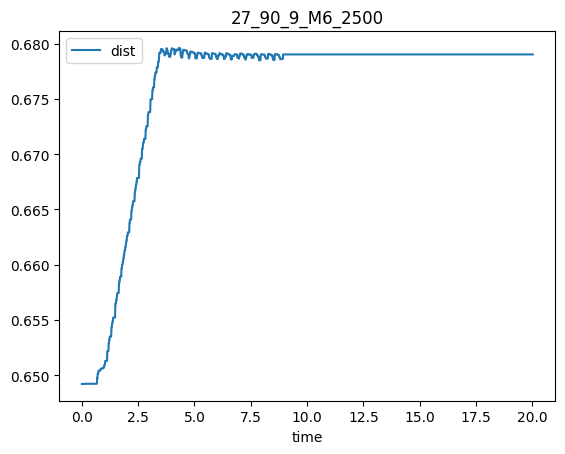

0.0


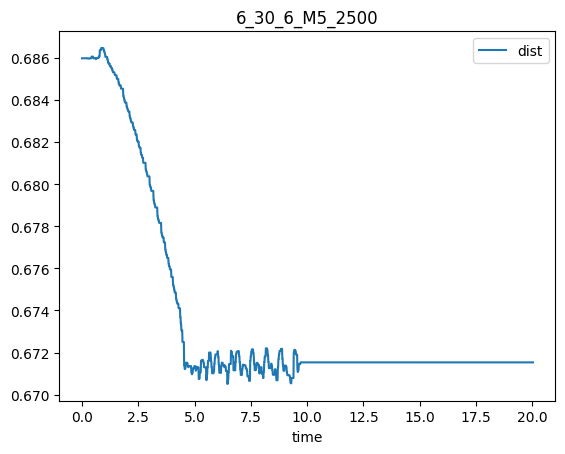

In [6]:
for subdir in subdirs:

    observation_path = os.path.join(data_dir, subdir, observation_file)
    sensor_path = os.path.join(data_dir, subdir, sensor_file)
    
    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    obs_df['ref_time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    sen_df['time'] = pd.to_datetime(sen_df['time'])
    obs_df['ref_time'] = (obs_df['ref_time'] - obs_df['ref_time'].min()).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2 + sen_df['Z'] ** 2)

    is_increasing = sen_df['dist'].iloc[-1] - sen_df['dist'].iloc[0] > 0
    tp_idx = sen_df[sen_df['dist'] >= 0.9999 * sen_df['dist'].max()].index.min() if is_increasing else \
        sen_df[sen_df['dist'] >= 1.0001 * sen_df['dist'].min()].index.min()

    print(sen_df.iloc[tp_idx]['time'])

    sen_df.plot(x='time', y=['dist'], kind='line')
    plt.title(label=subdir)
    plt.show()

screw_init_index: 330
before outlier removal: 601
after outlier removal: 548


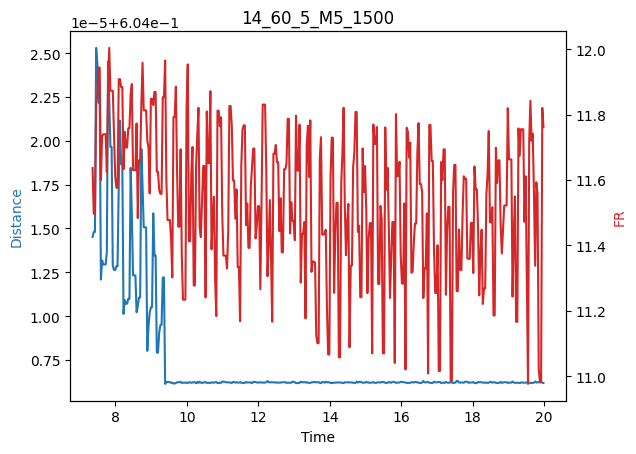

screw_init_index: 608
before outlier removal: 601
after outlier removal: 579


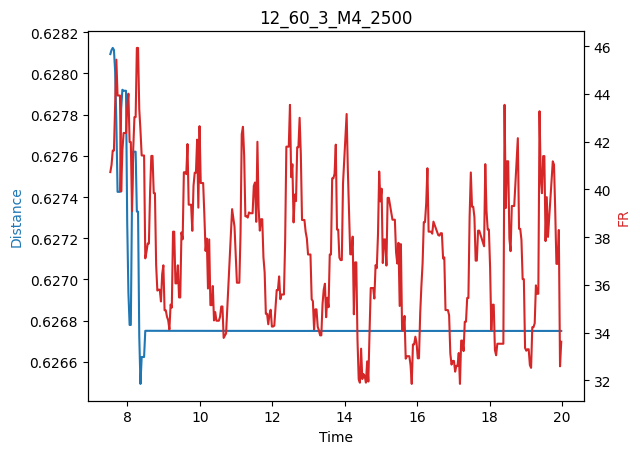

screw_init_index: 298
before outlier removal: 601
after outlier removal: 579


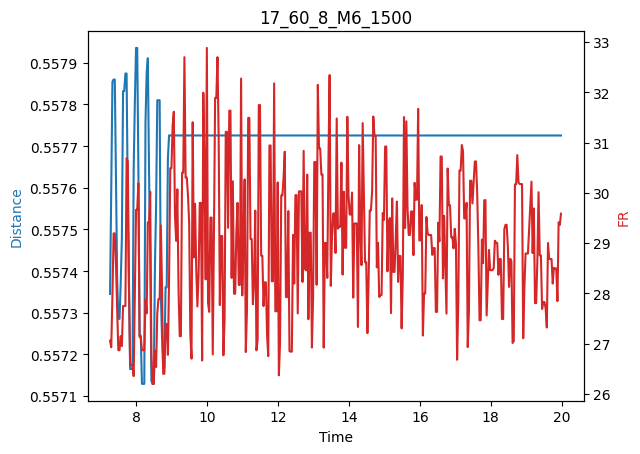

screw_init_index: 690
before outlier removal: 601
after outlier removal: 547


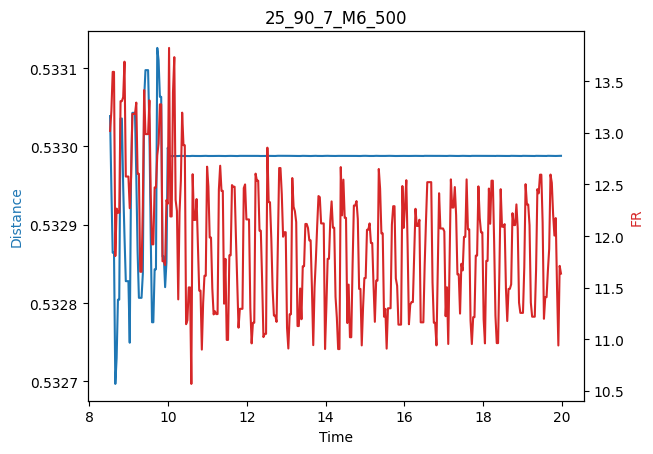

screw_init_index: 415
before outlier removal: 601
after outlier removal: 558


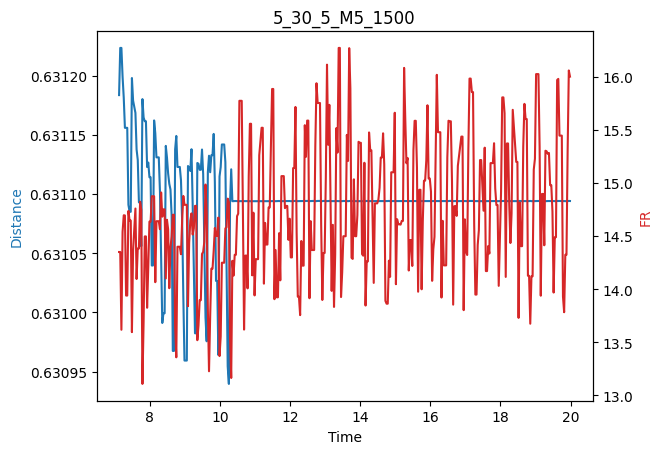

screw_init_index: 694
before outlier removal: 601
after outlier removal: 564


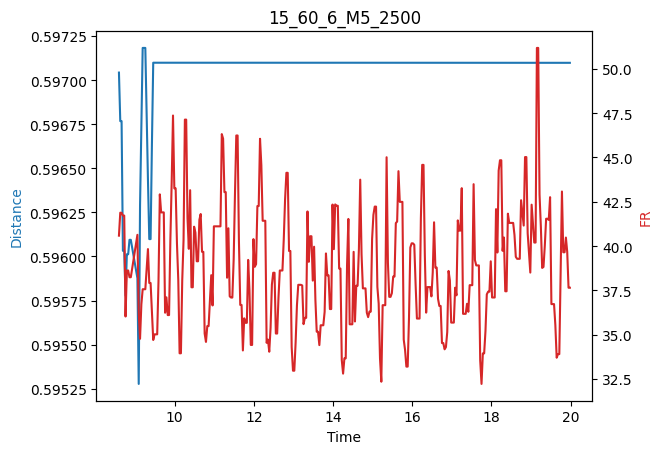

screw_init_index: 475
before outlier removal: 601
after outlier removal: 569


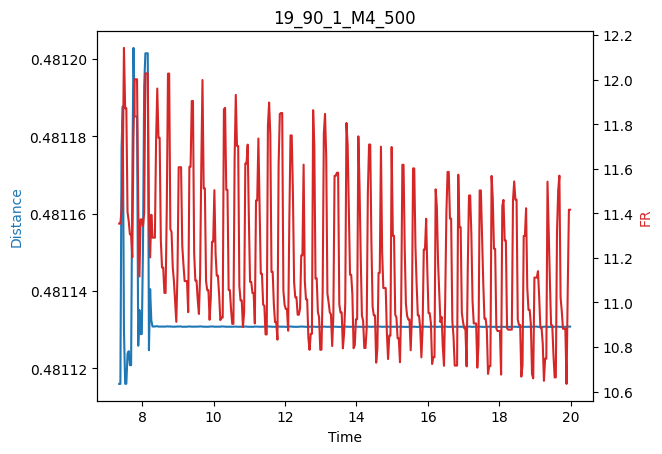

screw_init_index: 553
before outlier removal: 601
after outlier removal: 601


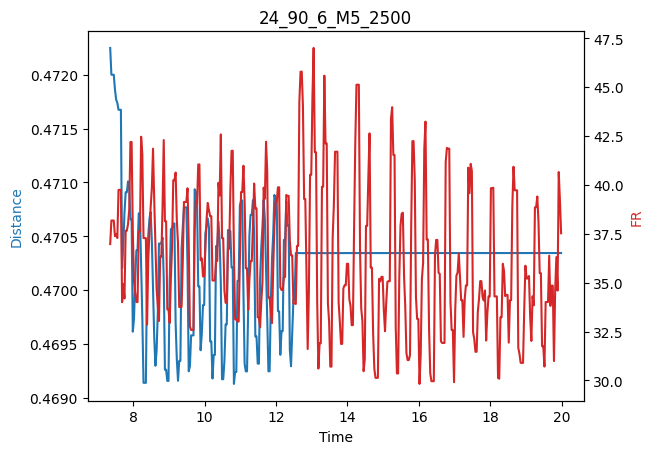

screw_init_index: 349
before outlier removal: 601
after outlier removal: 601


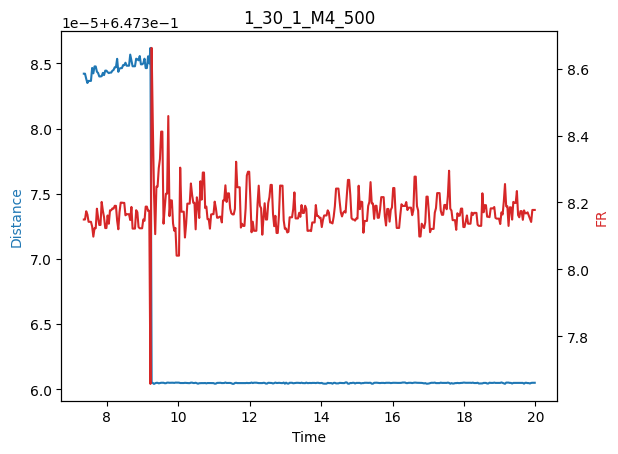

screw_init_index: 285
before outlier removal: 601
after outlier removal: 522


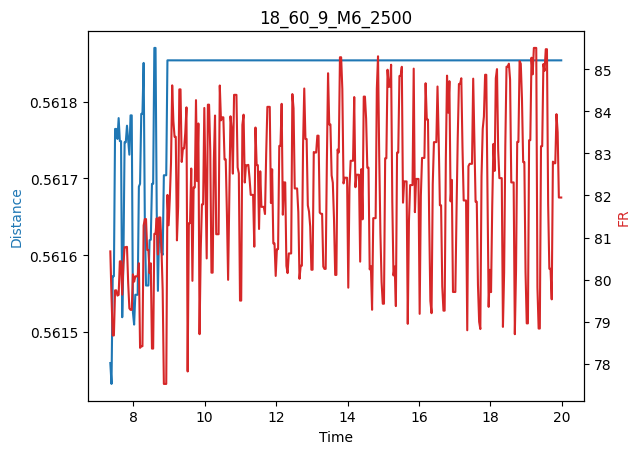

screw_init_index: 460
before outlier removal: 601
after outlier removal: 601


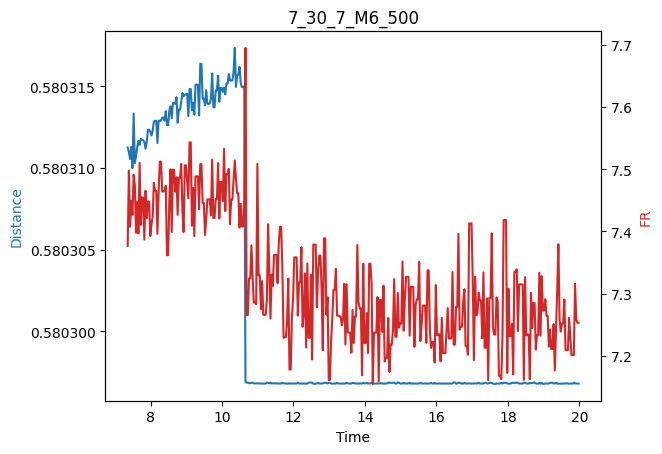

screw_init_index: 299
before outlier removal: 601
after outlier removal: 572


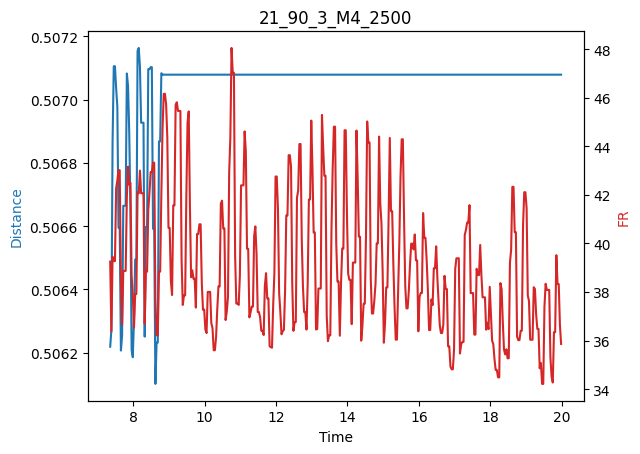

screw_init_index: 253
before outlier removal: 601
after outlier removal: 564


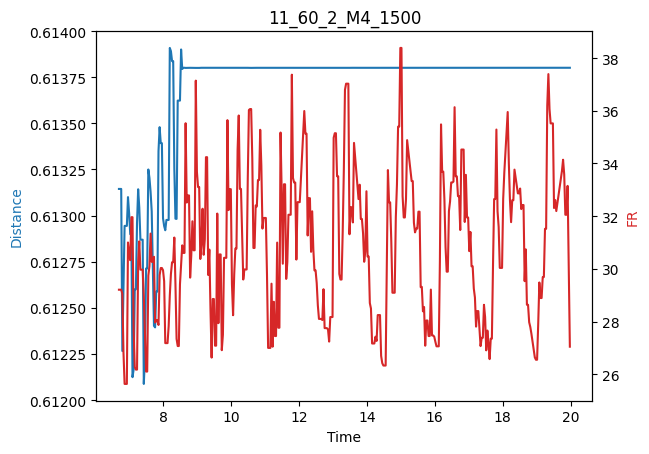

screw_init_index: 361
before outlier removal: 601
after outlier removal: 539


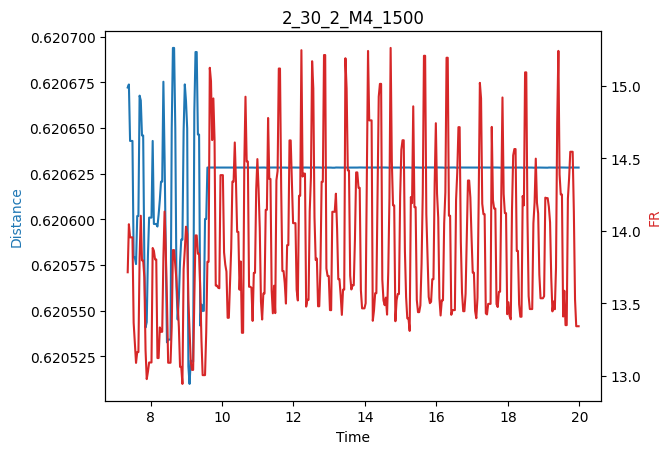

screw_init_index: 268
before outlier removal: 601
after outlier removal: 560


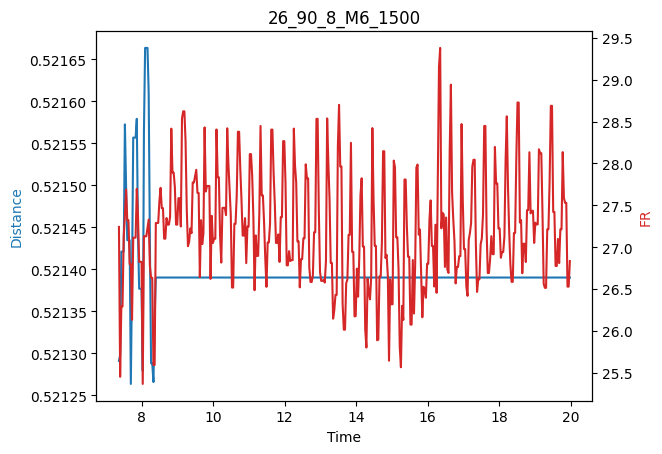

screw_init_index: 376
before outlier removal: 600
after outlier removal: 569


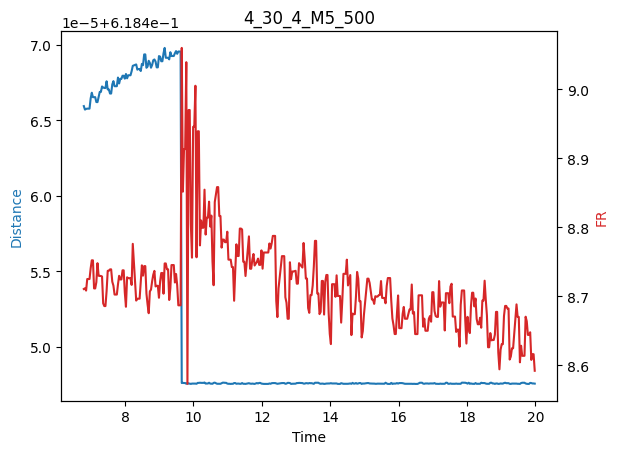

screw_init_index: 401
before outlier removal: 601
after outlier removal: 596


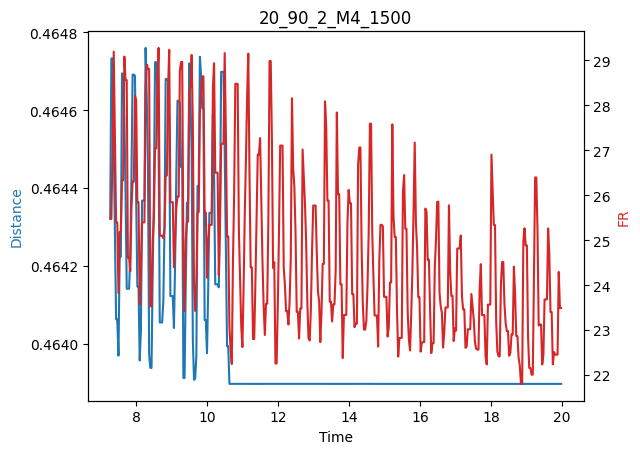

screw_init_index: 345
before outlier removal: 601
after outlier removal: 523


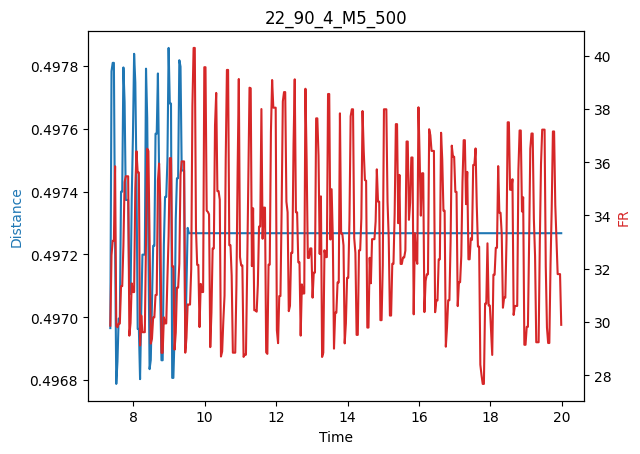

screw_init_index: 315
before outlier removal: 601
after outlier removal: 541


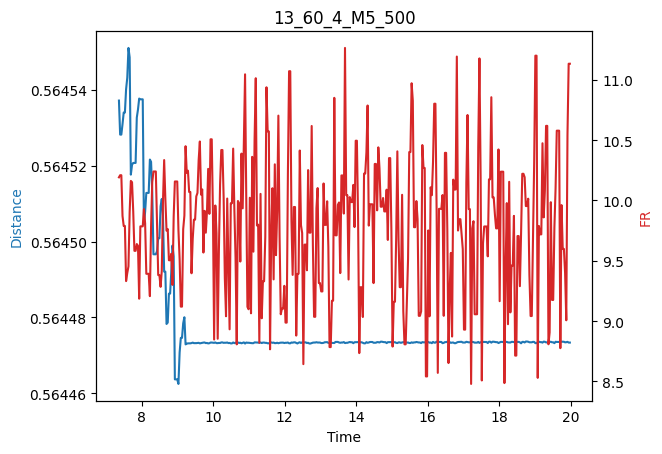

screw_init_index: 311
before outlier removal: 601
after outlier removal: 550


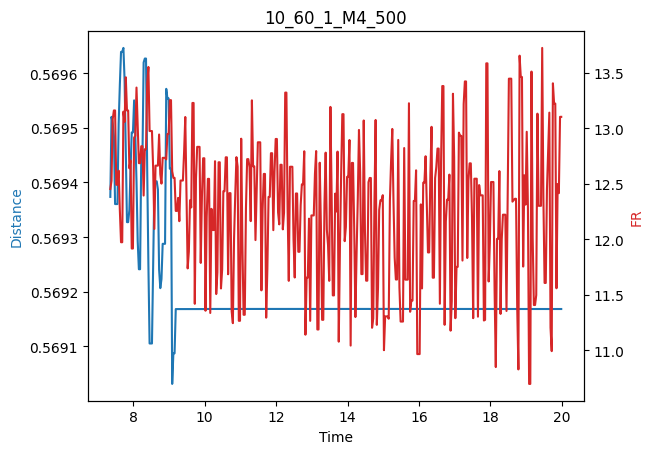

screw_init_index: 293
before outlier removal: 1202
after outlier removal: 1147


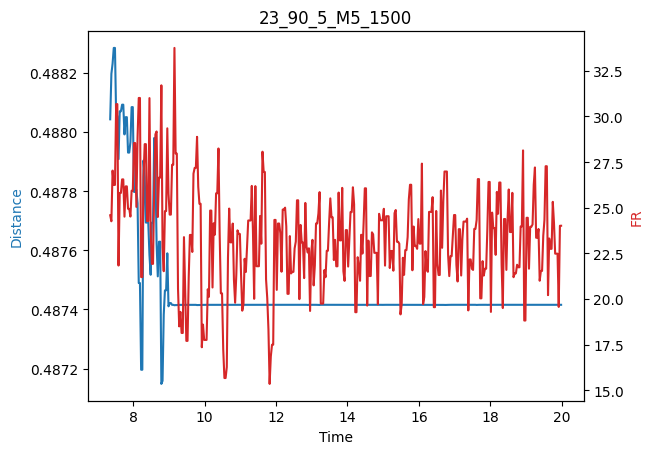

screw_init_index: 589
before outlier removal: 601
after outlier removal: 601


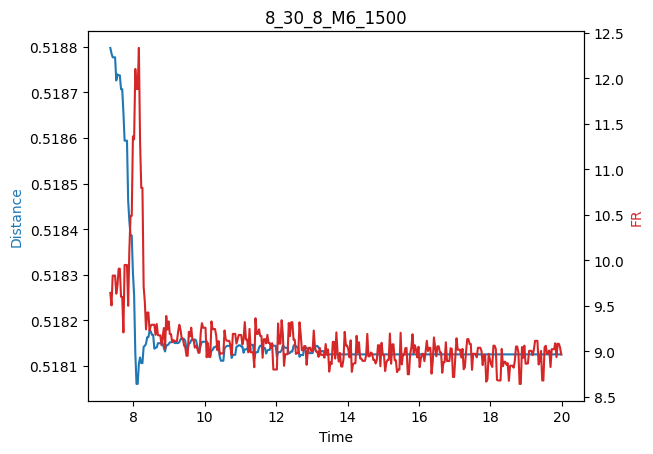

screw_init_index: 364
before outlier removal: 601
after outlier removal: 541


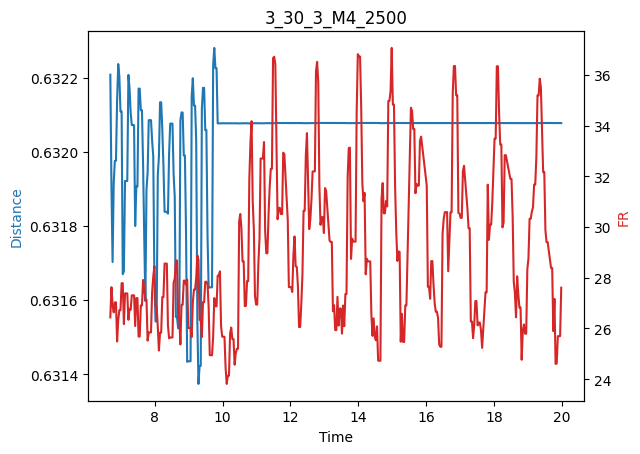

screw_init_index: 374
before outlier removal: 601
after outlier removal: 586


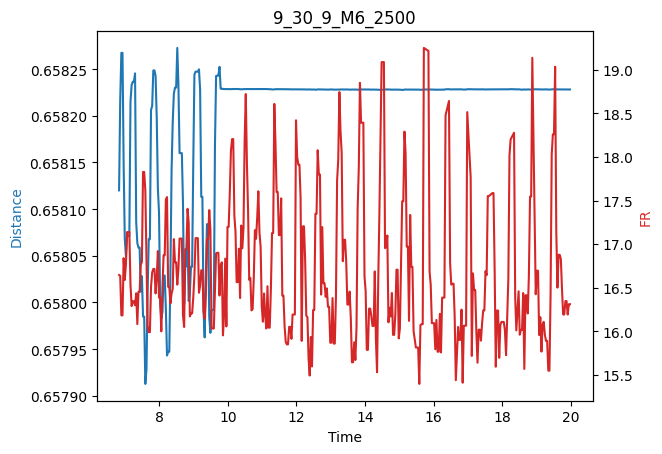

screw_init_index: 292
before outlier removal: 601
after outlier removal: 560


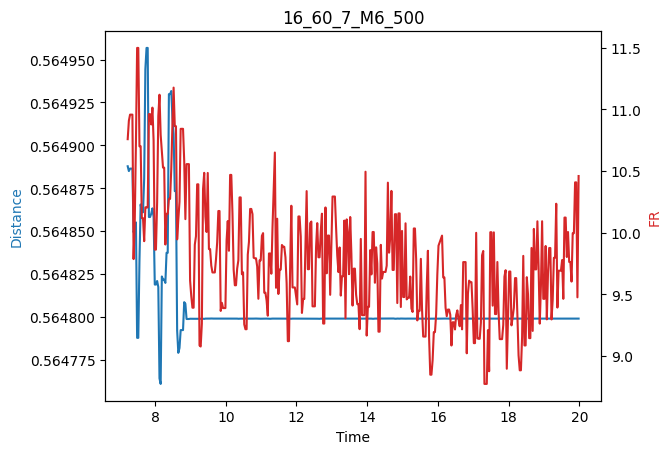

screw_init_index: 304
before outlier removal: 601
after outlier removal: 593


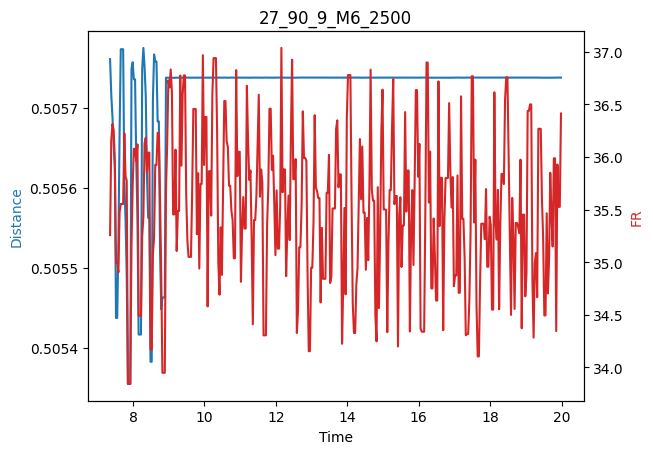

screw_init_index: 347
before outlier removal: 601
after outlier removal: 547


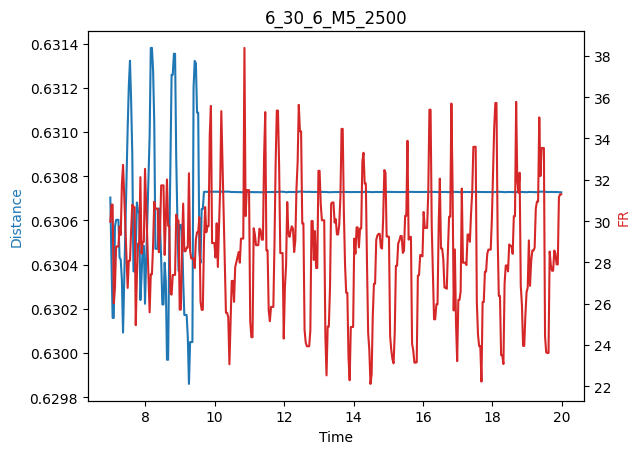

In [7]:
offset = -0.010  # seconds (sensor is this much time ahead of the camera, minus means behind; manually verified with the image timestamp)
df_list = []
skiplist = [
    '17_60_8_M6_1500', '5_30_5_M5_1500', '15_60_6_M5_2500', '24_90_6_M5_2500', '18_60_9_M6_2500',
    '21_90_3_M4_2500', '11_60_2_M4_1500', '4_30_4_M5_500', '20_90_2_M4_1500', '22_90_4_M5_500',
    '10_60_1_M4_500', '23_90_5_M5_1500', '3_30_3_M4_2500', '16_60_7_M6_500', '6_30_6_M5_2500',
]
skiplist = []

def detect_outliers(series, threshold=2):
    mean = series.mean()
    std = series.std()
    return (series - mean).abs() > threshold * std

for subdir in subdirs:
    observation_path = os.path.join(data_dir, subdir, observation_file)
    sensor_path = os.path.join(data_dir, subdir, sensor_file)
    
    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    
    obs_df['time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    obs_df['time'] = (obs_df['time'] - obs_df['time'].min()).dt.total_seconds()
    
    sen_df['time'] = pd.to_datetime(sen_df['time'])    
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] + offset)

    observation_path_out = os.path.join(data_dir, subdir, 'aligned_{}'.format(observation_file))
    sensor_path_out = os.path.join(data_dir, subdir, 'aligned_{}'.format(sensor_file))
    obs_df.to_csv(observation_path_out, index=False)
    sen_df.to_csv(sensor_path_out, index=False)

    sen_df['fr'] = np.sqrt(sen_df['fx'] ** 2 + sen_df['fy'] ** 2 + sen_df['fz'] ** 2)
    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2)
    tp_idx = sen_df[sen_df['dist'] >= sen_df['dist'].max() * 0.9999].index.min()
    min_after_tp = sen_df['dist'].loc[tp_idx:].min()
    thresh = 0.10 * min_after_tp
    tp_idx = sen_df['dist'].loc[tp_idx:].index[sen_df['dist'].loc[tp_idx:] <= min_after_tp + thresh].min()
    print('screw_init_index: {}'.format(tp_idx))
    trim_time = sen_df['time'][tp_idx]

    outlier_mask = obs_df[['X', 'Y', 'Z']].apply(detect_outliers)
    print('before outlier removal: {}'.format(obs_df.shape[0]))
    obs_df = obs_df[~outlier_mask.any(axis=1)]
    print('after outlier removal: {}'.format(obs_df.shape[0]))
    
    tolerance = np.abs(offset)        
    merged_df = pd.merge_asof(obs_df, sen_df.drop(columns=['X', 'Y', 'Z']), on='time', tolerance=tolerance, direction='nearest')
    merged_df = merged_df[merged_df['time'] >= trim_time]
    if merged_df.shape[0] > 0:
        merged_df['X'] = merged_df['X'] / 1000  # norm to meters
        merged_df['Y'] = merged_df['Y'] / 1000  # norm to meters
        merged_df['Z'] = merged_df['Z'] / 1000  # norm to meters
    merged_df = merged_df.dropna()
    merged_df.reset_index(drop=True, inplace=True)
    merged_path_out = os.path.join(data_dir, subdir, merged_file)

    
    for column in ['X', 'Y', 'Z']:
        merged_df[column] = merged_df[column].ewm(alpha=0.3).mean()
    merged_df = merged_df.tail(380)

    fig, ax1 = plt.subplots()
    ax1.plot(merged_df['time'], merged_df['dist'], color='tab:blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Distance', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(merged_df['time'], merged_df['fr'], color='tab:red')
    ax2.set_ylabel('FR', color='tab:red')
    plt.title(subdir)
    plt.show()

    fig = go.Figure(data=[go.Scatter3d(
        x=merged_df['X'],
        y=merged_df['Y'],
        z=merged_df['Z'],
        mode='markers',
        marker=dict(
            size=1,
            opacity=0.8
        ),
    )])
    fig.update_layout(width=800, height=400)
    fig.show()

    merged_df.to_csv(merged_path_out, index=False)

    if subdir in skiplist:
        print('skipping {}'.format(subdir))
        continue
    
    df_list.append(merged_df)


In [8]:
combined_df = pd.concat(df_list, ignore_index=True)
combined_df

time         X         Y         Z         A         B         C  \
0       7.359379  0.380644  0.236595  1.579754 -1.419744  1.088865  0.178991   
1       7.392680  0.380421  0.236798  1.579754 -1.419737  1.088861  0.179002   
2       7.425982  0.379973  0.236749  1.579754 -1.419737  1.088861  0.179002   
3       7.459282  0.379557  0.236388  1.579754 -1.419791  1.088900  0.178980   
4       7.492585  0.379406  0.235738  1.579754 -1.419795  1.088901  0.178985   
...          ...       ...       ...       ...       ...       ...       ...   
10151  19.847650  0.333387  0.237790  1.638990  3.078408  0.054515 -0.662638   
10152  19.880948  0.333101  0.238252  1.638990  3.078408  0.054515 -0.662638   
10153  19.914247  0.332779  0.238676  1.638990  3.078398  0.054518 -0.662642   
10154  19.947546  0.332563  0.238807  1.638990  3.078396  0.054525 -0.662645   
10155  19.980844  0.332678  0.238265  1.638990  3.078400  0.054525 -0.662643   

             Vx        Vy            Vz  ...  Rot_Cy  Rot_Cz      Kx      Ky  \
0     -0.000011 -0.000027  5.234365e-06  ...     0.7     0.7   500.0   500.0   
1     -0.000011 -0.000027  5.234365e-06  ...     0.7     0.7   500.0   500.0   
2     -0.000011 -0.000027  5.234365e-06  ...     0.7     0.7   500.0   500.0   
3     -0.000011 -0.000027  5.234365e-06  ...     0.7     0.7   500.0   500.0   
4     -0.000011 -0.000027  5.234365e-06  ...     0.7     0.7   500.0   500.0   
...         ...       ...           ...  ...     ...     ...     ...     ...   
10151 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   
10152 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   
10153 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   
10154 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   
10155 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   

           Kz  Rot_Kx  Rot_Ky  Rot_Kz         fr      dist  
0       500.0   500.0   500.0   500.0  11.636532  0.604015  
1       500.0   500.0   500.0   500.0  11.496754  0.604015  
2       500.0   500.0   500.0   500.0  11.496754  0.604015  
3       500.0   500.0   500.0   500.0  11.830293  0.604025  
4       500.0   500.0   500.0   500.0  11.862296  0.604024  
...       ...     ...     ...     ...        ...       ...  
10151  2500.0  2500.0  2500.0  2500.0  27.904218  0.630728  
10152  2500.0  2500.0  2500.0  2500.0  27.904218  0.630728  
10153  2500.0  2500.0  2500.0  2500.0  31.157348  0.630728  
10154  2500.0  2500.0  2500.0  2500.0  31.300417  0.630727  
10155  2500.0  2500.0  2500.0  2500.0  31.300417  0.630727  

[10156 rows x 33 columns]

In [9]:
train_df, test_df = train_test_split(combined_df, test_size=0.2)
val_df, test_df = train_test_split(test_df, test_size=0.5)

print(train_df.shape, val_df.shape, test_df.shape)

(8124, 33) (1016, 33) (1016, 33)


In [10]:
train_file_path = os.path.join(out_dir, train_file)
val_file_path = os.path.join(out_dir, validation_file)
test_file_path = os.path.join(out_dir, test_file)

train_df.to_csv(train_file_path, index=False)
val_df.to_csv(val_file_path, index=False)
test_df.to_csv(test_file_path, index=False)